<a href="https://colab.research.google.com/github/bloomfieldfong/Stadistical-Learning/blob/main/Tarea2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [105]:
covid19_data = pd.read_csv('/content/drive/My Drive/covid_19_clean_complete.csv')

In [106]:
covid19_sort = covid19_data.sort_values(by=["Date"])
type(covid19_sort["Date"][0])

str

In [107]:
date = covid19_sort["Date"].unique()
fecha_corr = []
cont = 0
for i in date:
  cont += 1
  fecha_corr.append([str(i),cont])

In [108]:
for i in fecha_corr:
  covid19_sort["Date"] = covid19_sort["Date"].replace(i[0], i[1])
covid19_sort

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.939110,67.709953,1,0,0,0,0,Eastern Mediterranean
166,Sint Maarten,Netherlands,18.042500,-63.054800,1,0,0,0,0,Europe
167,NaN,Netherlands,52.132600,5.291300,1,0,0,0,0,Europe
168,NaN,New Zealand,-40.900600,174.886000,1,0,0,0,0,Western Pacific
169,NaN,Nicaragua,12.865416,-85.207229,1,0,0,0,0,Americas
...,...,...,...,...,...,...,...,...,...,...
48899,NaN,Denmark,56.263900,9.501800,188,13547,613,12417,517,Europe
48900,NaN,Djibouti,11.825100,42.590300,188,5059,58,4977,24,Eastern Mediterranean
48901,NaN,Dominican Republic,18.735700,-70.162700,188,64156,1083,30204,32869,Americas
48903,NaN,Egypt,26.820553,30.802498,188,92482,4652,34838,52992,Eastern Mediterranean


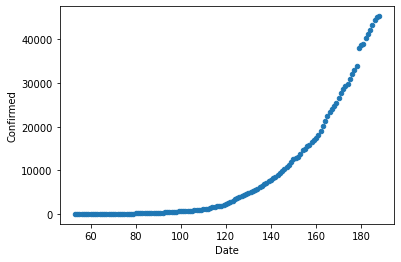

In [109]:
GT_confirmed = covid19_sort[(covid19_sort["Country/Region"] == 'Guatemala') & (covid19_sort["Confirmed"] > 0)].copy()
GT_confirmed.plot.scatter(x = "Date",y="Confirmed")

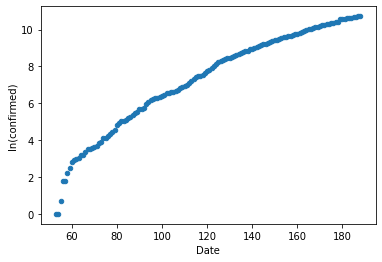

In [110]:
GT_confirmed["ln(confirmed)"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Date",y="ln(confirmed)")

In [237]:
def modelo(x,y, epochs, imprimir_error_cada, lr):
  #MB = [[0.0], [0.0]] variables m y b 
  mb = tf.Variable(name="mb", initial_value=tf.zeros((2,1),tf.float64))
  #Reshape el valor de y 
  y = y.reshape(len(y), 1)
  #Reshape el valor x a una lista  con 1s [y,1] para operaciones matriciales
  x = x.reshape(len(x), 1)
  x = tf.concat([x, tf.ones_like(x)], axis=1)
  errores = []
  mbs = []
  #Recorre en cantidad de epochs
  for i in range(epochs):
    with tf.GradientTape() as grad_tape:
      #Multiplicacion matricial para crear la prediccion de y 
      y_pred = tf.matmul(x,mb)
      #Calculo del error
      error = 1/2 * tf.reduce_mean(tf.math.square(y - y_pred))
    #Calculo de la gradiente
    grad_mb = grad_tape.gradient(error, mb)
    #Re-asignar la nueva m y b 
    mb.assign(mb-lr*grad_mb[0])
    #Errores
    errores.append(error.numpy())
    mbs.append(mb.numpy())
    
    if ((i+1) % imprimir_error_cada) == 0:
      print("Error Iteracion: "+ str(i+1)+" "+str(errores[i]))
      print("    modelo:y={}x+{}".format(mbs[i][0],mbs[i][1]))

  return mbs[-1]

In [239]:
def prediccion_lineal(x, mbs):
  return mb[0]*x + mb[1]

In [248]:
date = GT_confirmed["Date"].to_numpy()
date = date.astype('float64')
confirmed = GT_confirmed["ln(confirmed)"].to_numpy()
confirmed = confirmed.astype('float64')
mb = modelo(confirmed,date,100, 100, 0.001)

## del 22 de abril al 30 de mayo existen 38 dias
dia30_mayo = prediccion_lineal(38, mb[0])
print("Se tendran "+str(int(dia30_mayo[0]))+" casos confirmados para el 30 de Mayo")


Error Iteracion: 100 40.403663018604306
    modelo:y=[14.5271488]x+[14.5271488]
Se tendran 566 casos confirmados para el 30 de Mayo


### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

In [5]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [255]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


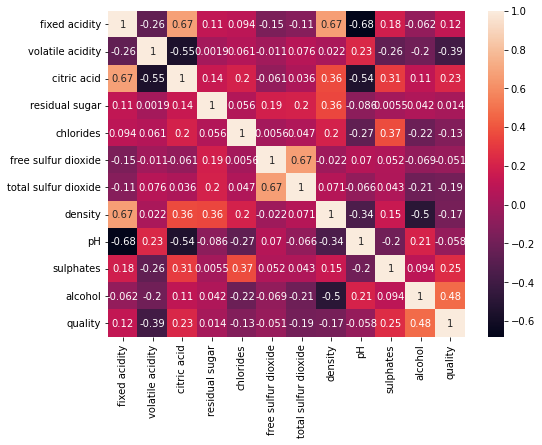

In [256]:
correlation_table = data.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_table, annot=True)
plt.show()

Analizando la tabla de correlacion tomando en cuenta que la variable de prediccion es ""Quality" las variables con mas correlacion son "alcohol" y "sulphates".

In [6]:
y = data[['quality']]
x = data[['sulphates', 'alcohol']]

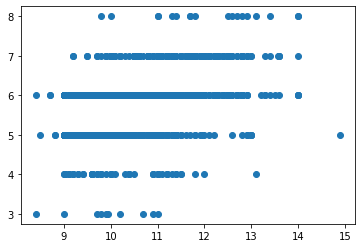

In [265]:
plt.scatter(x['alcohol'], y)

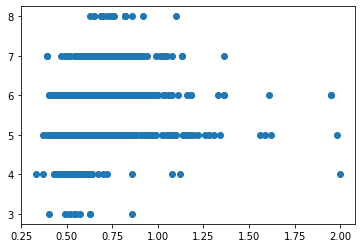

In [266]:
plt.scatter(x['sulphates'], y)

### Tabla 
 $[1,a,b,a^{2},b^{2},ab]$

In [300]:
valorx = x.copy()
valorx.columns=['a', 'b']
valorx['a^2'] = valorx['a']*valorx['a']
valorx['b^2'] = valorx['b']*valorx['b']
valorx['ab'] = valorx['a']*valorx['b']
valorx['1'] = 1
valorx.head()

,a,b,a^2,b^2,ab,1
0,0.56,9.4,0.3136,88.36,5.264,1
1,0.68,9.8,0.4624,96.04,6.664,1
2,0.65,9.8,0.4225,96.04,6.370,1
3,0.58,9.8,0.3364,96.04,5.684,1
4,0.56,9.4,0.3136,88.36,5.264,1


In [308]:
poly = PolynomialFeatures(2)
poly.fit_transform(x)
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(x)

array([[ 1.   ,  0.56 ,  9.4  ,  5.264],
       [ 1.   ,  0.68 ,  9.8  ,  6.664],
       [ 1.   ,  0.65 ,  9.8  ,  6.37 ],
       ...,
       [ 1.   ,  0.75 , 11.   ,  8.25 ],
       [ 1.   ,  0.71 , 10.2  ,  7.242],
       [ 1.   ,  0.66 , 11.   ,  7.26 ]])

In [32]:
def modelo_polinomeal(x,y,epochs,lr, imprimir_cada):
  #MB = [[0.0], [0.0], [0,0]] variables b1 + b2x + b3x^2
  teta = tf.Variable(name="teta", initial_value=tf.zeros((3,1),tf.float64))
  #Reshape el valor de y 
  y = y.reshape(len(y), 1)
  #Reshape el valor x a una lista  con 1s [y,1] para operaciones matriciales
  x = x.reshape(len(x), 1)
  x = tf.concat([x, tf.ones_like(x)], axis=1)
  errores = []
  tetas = []
  #Recorre en cantidad de epochs
  for i in range(epochs):
    with tf.GradientTape() as grad_tape:
      #Multiplicacion matricial para crear la prediccion de y 
      y_pred = tf.matmul(x,teta) 
      #Calculo del error
      error = 1/2 * tf.reduce_mean(tf.math.square(y - y_pred))
    #Calculo de la gradiente
    grad_teta = grad_tape.gradient(error, teta)
    #Re-asignar la nueva m y b 
    teta.assign(teta-lr*grad_teta[0])
    #Errores
    errores.append(error.numpy())
    tetas.append(teta.numpy())
    
    if ((i+1) % imprimir_error_cada) == 0:
      print("Error Iteracion: "+ str(i+1)+" "+str(errores[i]))
      print("    modelo:y={}x+{}".format(tetas[i][0],tetas[i][1]))

  return tetas[-1]

In [31]:
tetas = modelo_polinomeal(x.to_numpy(), y.to_numpy(),100,0.01, 10)

InvalidArgumentError: ignored